# Implementing a Multilayer Perceptron (MNIST)

## 1) Installing Libraries

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Matplotlib created a temporary cache directory at /tmp/matplotlib-k41rxp9y because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.17.2

numpy     : 1.26.2
pandas    : 2.1.4
matplotlib: 3.8.2
torch     : 2.1.2+cu121



## 1) Downloading the data

- Fashion MNIST website: https://github.com/zalandoresearch/fashion-mnist

In [14]:
from git import Repo
import os
import numpy as np

In [5]:
if not os.path.exists("fashion-mnist"):
    Repo.clone_from("https://github.com/zalandoresearch/fashion-mnist", "fashion-mnist")

## 2) Loading the dataset

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [16]:
train, y_train = load_mnist("fashion-mnist/data/fashion")
test, y_test = load_mnist("fashion-mnist/data/fashion", kind="t10k")

In [18]:
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (60000, 784)
Test data shape: (10000, 784)


In [19]:
print(f"Train data label distribution: {np.bincount(y_train)}")
print(f"Test data label distribution: {np.bincount(y_test)}")

Train data label distribution: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Test data label distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [31]:
from torch.utils.data import DataLoader, Dataset


class MyDataset(Dataset):
    def __init__(self, features, labels, transform=None):

        self.features = features
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):

        img = self.features[index]
        y = self.labels[index]

        img = torch.tensor(img).to(torch.float32)
        img = img/255.

        if self.transform is not None:
            img = self.transform(img)

        return img, y

    def __len__(self):
        return self.labels.shape[0]

In [32]:
train_dataset = MyDataset(train, y_train)
test_dataset = MyDataset(test, y_test)

In [33]:
len(train_dataset)

60000

In [34]:
len(test_dataset)

10000

### Create a validation set

In [35]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [36]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

### Evaluating a few batches

In [37]:
import time

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        time.sleep(1)
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

print("Labels from current batch:", y)

 Batch index: 0 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
 Batch index: 1 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
 Batch index: 2 | Batch size: 64 | x shape: torch.Size([64, 784]) | y shape: torch.Size([64])
Labels from current batch: tensor([4, 8, 9, 9, 9, 0, 6, 4, 7, 6, 0, 1, 7, 7, 7, 1, 3, 9, 7, 8, 8, 6, 9, 1,
        3, 8, 2, 2, 6, 6, 1, 3, 0, 4, 0, 7, 6, 4, 8, 2, 1, 3, 0, 5, 4, 8, 1, 1,
        2, 7, 7, 0, 5, 3, 9, 4, 2, 2, 3, 3, 5, 2, 1, 9], dtype=torch.uint8)


## 3) Implementing the model

In [38]:
import torch

class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes, hl=[50, 25]):
        super().__init__()
        
        n_hl = len(hl)

        # Starts with the head/input layer
        layers = [torch.nn.Linear(num_features, hl[0]), torch.nn.ReLU()]

        # Intermediate layers
        if n_hl > 1:
            for l in range(1, n_hl):
                layers.append(torch.nn.Linear(hl[l-1], hl[l]))

        # Output layers
        layers.append(torch.nn.Linear(hl[-1], num_classes))

        self.all_layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

In [39]:
def print_number_params(model):

    n_params = sum(p.numel() for p in model.parameters())

    print(n_params)

## 4) The training loop

In [40]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [43]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10, hl=[32, 32])

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/030 | Batch 000/860 | Train Loss: 2.31


Epoch: 001/030 | Batch 250/860 | Train Loss: 1.62
Epoch: 001/030 | Batch 500/860 | Train Loss: 1.05
Epoch: 001/030 | Batch 750/860 | Train Loss: 0.90
Train Acc 71.07% | Val Acc 72.24%
Epoch: 002/030 | Batch 000/860 | Train Loss: 0.80
Epoch: 002/030 | Batch 250/860 | Train Loss: 0.60
Epoch: 002/030 | Batch 500/860 | Train Loss: 0.69
Epoch: 002/030 | Batch 750/860 | Train Loss: 0.67
Train Acc 77.12% | Val Acc 77.34%
Epoch: 003/030 | Batch 000/860 | Train Loss: 0.84
Epoch: 003/030 | Batch 250/860 | Train Loss: 0.59
Epoch: 003/030 | Batch 500/860 | Train Loss: 0.49
Epoch: 003/030 | Batch 750/860 | Train Loss: 0.75
Train Acc 79.71% | Val Acc 80.00%
Epoch: 004/030 | Batch 000/860 | Train Loss: 0.69
Epoch: 004/030 | Batch 250/860 | Train Loss: 0.55
Epoch: 004/030 | Batch 500/860 | Train Loss: 0.42
Epoch: 004/030 | Batch 750/860 | Train Loss: 0.36
Train Acc 79.20% | Val Acc 79.46%
Epoch: 005/030 | Batch 000/860 | Train Loss: 0.62
Epoch: 005/030 | Batch 250/860 | Train Loss: 0.65
Epoch: 005/030

## 5) Evaluating the results

Benchmark is training accuracy of 85%

In [44]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 87.61%
Val Acc 86.64%
Test Acc 85.42%


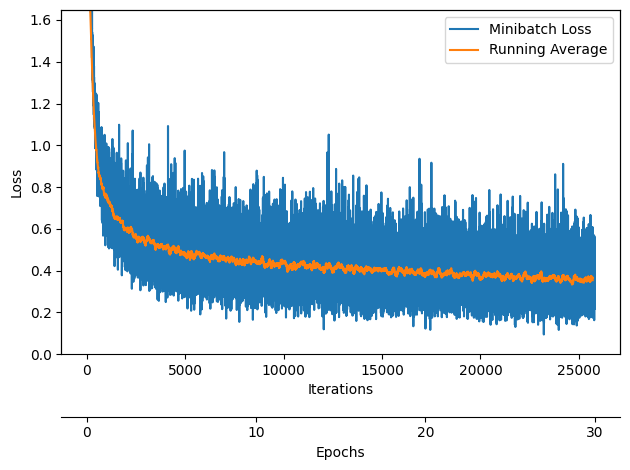

In [45]:
from helper_plotting import plot_training_loss

plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

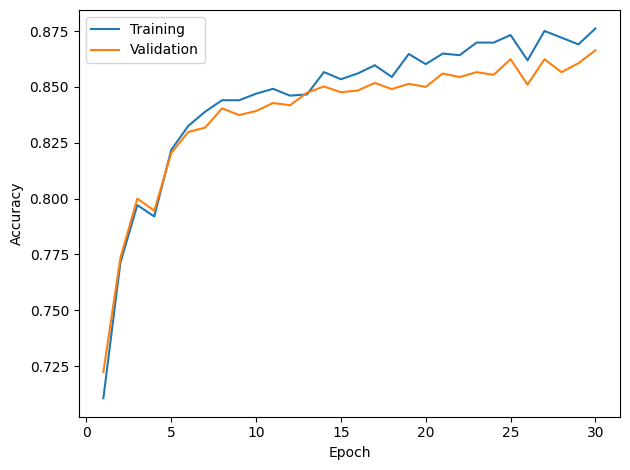

In [46]:
from helper_plotting import plot_accuracy

plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=val_acc_list)